In [1]:
from comet_ml import Experiment
import torch.nn as nn
import torch.nn.functional as F
from model import *
from torch.autograd import Variable
import itertools

import torch 
from torch.optim import Adam, lr_scheduler
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torch.utils.data import Dataset

import pickle

In [3]:
experiment = Experiment(
    api_key="HyWl3zINDt5tVxrEffWKpJ0Ms",
    project_name="deep-learning",
    workspace="jjiang",
)

# Report multiple hyperparameters using a dictionary:
hyper_params = {
    "learning_rate": 0.5,
    "model" : 'CycleGAN',
    "EPOCHS": 200,
    "batch_size": 32,
}
experiment.log_parameters(hyper_params)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/jjiang/deep-learning/417145934cca42829fa9ecddea8d4be8

COMET ERROR: Error logging git-related information


In [4]:


def save_weather(obj, name ):
    with open('/cluster/scratch/zhejiang/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
        
def load_weather(name):
    with open('/cluster/scratch/zhejiang/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [5]:
overcast = load_weather('overcast')[:100]
snow = load_weather('snow')[:100]

In [6]:
# snow[0].shape
# image = snow[0][:,:,0:3]
# print(image.shape)
# image = image.permute(2, 0, 1)
# image.shape

In [7]:
input_shape = (3, 180, 320)

In [8]:
class LambdaLR:
    def __init__(self, n_epochs, offset, decay_start_epoch):
        assert (n_epochs - decay_start_epoch) > 0, "Decay must start before the training session ends!"
        self.n_epochs = n_epochs
        self.offset = offset
        self.decay_start_epoch = decay_start_epoch

    def step(self, epoch):
        return 1.0 - max(0, epoch + self.offset - self.decay_start_epoch) / (self.n_epochs - self.decay_start_epoch)

In [9]:
class ImageDataset(Dataset):
    def __init__(self, A,B):
        self.A = A
        self.B = B

    def __getitem__(self, index):
        image_A = self.A[index][:,:,0:3].permute(2, 0, 1)
        image_B = self.B[index][:,:,0:3].permute(2, 0, 1)
        return {"A": image_A, "B": image_B}

    def __len__(self):
        return max(len(self.A), len(self.B))

In [10]:
dataset = DataLoader(ImageDataset(snow, overcast), 
                     batch_size = 16, shuffle=True )

In [11]:
# for i,v in enumerate(dataset):
#     print(len(v['A']))
#     break

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [13]:
criterion_GAN = torch.nn.MSELoss().to(device)
criterion_cycle = torch.nn.L1Loss().to(device)
criterion_identity = torch.nn.L1Loss().to(device)

In [14]:
G_AB = Generator(input_shape,9)
G_BA =Generator(input_shape,9)
D_A = Discriminator(input_shape)
D_B = Discriminator(input_shape)

In [15]:
G_AB.apply(weights_init_normal)
G_BA.apply(weights_init_normal)
D_A.apply(weights_init_normal)
D_B.apply(weights_init_normal)

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): ZeroPad2d(padding=(1, 0, 1, 0), value=0.0)
    (12): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  )
)

In [16]:
G_AB.to(device)
G_BA.to(device)
D_A.to(device)
D_B.to(device)

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): ZeroPad2d(padding=(1, 0, 1, 0), value=0.0)
    (12): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  )
)

In [18]:

beta = (0.5, 0.999)
lr = 2e-4
decay = 100

In [19]:
optimizer_G = Adam(
    itertools.chain(G_AB.parameters(), G_BA.parameters()), lr=lr, betas=beta
)
optimizer_D_A = Adam(D_A.parameters(), lr=lr, betas=beta)
optimizer_D_B = Adam(D_B.parameters(), lr=lr, betas=beta)

# Learning rate update schedulers
lr_scheduler_G = lr_scheduler.LambdaLR(
    optimizer_G, lr_lambda=LambdaLR(200, 0, 100).step
)
lr_scheduler_D_A = lr_scheduler.LambdaLR(
    optimizer_D_A, lr_lambda=LambdaLR(200, 0, 100).step
)
lr_scheduler_D_B = lr_scheduler.LambdaLR(
    optimizer_D_B, lr_lambda=LambdaLR(200, 0, 100).step
)

In [20]:
# image.shape
import numpy as np
h = 180
w = 320
Tensor =  torch.Tensor

In [21]:
def sample_images(imgs, step):
    """Saves a generated sample from the test set"""
    G_AB.eval()
    G_BA.eval()
    
    real_A = imgs["A"][0]
    fake_B = G_AB(real_A).permute(1,2,0)
    real_B = imgs["B"][0]
    fake_A = G_BA(real_B).permute(1,2,0)
    
    experiment.log_image(fake_B/255, name="fake B", step = step)
    experiment.log_image(fake_A/255, name="fake A", step = step)
  

In [22]:
with experiment.train():
    step = 0
    for epoch in range(1):
        G_loss_val = 0
        for batch in dataset:
                real_A = batch["A"].to(device)
                real_B = batch["B"].to(device)

                valid = Variable(Tensor(np.ones((real_A.size(0), *D_A.output_shape))), requires_grad=False)
                fake = Variable(Tensor(np.zeros((real_A.size(0), *D_A.output_shape))), requires_grad=False)

                G_AB.train()
                G_BA.train()
                optimizer_G.zero_grad()

                # Identity loss
                loss_id_A = criterion_identity(G_BA(real_A), real_A)
                loss_id_B = criterion_identity(G_AB(real_B), real_B)

                loss_identity = (loss_id_A + loss_id_B) / 2

                # GAN loss
                fake_B = G_AB(real_A)
                loss_GAN_AB = criterion_GAN(D_B(fake_B), valid)
                fake_A = G_BA(real_B)
                loss_GAN_BA = criterion_GAN(D_A(fake_A), valid)

                loss_GAN = (loss_GAN_AB + loss_GAN_BA) / 2

                # Cycle loss
                recov_A = G_BA(fake_B)
                loss_cycle_A = criterion_cycle(recov_A, real_A)
                recov_B = G_AB(fake_A)
                loss_cycle_B = criterion_cycle(recov_B, real_B)

                loss_cycle = (loss_cycle_A + loss_cycle_B) / 2

                # Total loss
                loss_G = loss_GAN + 5 * loss_cycle + 10 * loss_identity
                G_loss_val += loss_G.item()
                loss_G.backward()
                optimizer_G.step()

                # -----------------------
                #  Train Discriminator A
                # -----------------------

                optimizer_D_A.zero_grad()

                # Real loss
                loss_real = criterion_GAN(D_A(real_A), valid)
                # Fake loss (on batch of previously generated samples)
                fake_A_ = fake_A_buffer.push_and_pop(fake_A)
                loss_fake = criterion_GAN(D_A(fake_A_.detach()), fake)
                # Total loss
                loss_D_A = (loss_real + loss_fake) / 2

                loss_D_A.backward()
                optimizer_D_A.step()

                # -----------------------
                #  Train Discriminator B
                # -----------------------

                optimizer_D_B.zero_grad()

                # Real loss
                loss_real = criterion_GAN(D_B(real_B), valid)
                # Fake loss (on batch of previously generated samples)
                fake_B_ = fake_B_buffer.push_and_pop(fake_B)
                loss_fake = criterion_GAN(D_B(fake_B_.detach()), fake)
                # Total loss
                loss_D_B = (loss_real + loss_fake) / 2

                loss_D_B.backward()
                optimizer_D_B.step()

                loss_D = (loss_D_A + loss_D_B) / 2
                
                # -----------------------
                #  Log
                # -----------------------
                batches_done = epoch * len(dataloader) + i
#                 if batches_done % 10 == 0:
#                     print(shape)
#                     sample_images(batch)
                print(real_A, real_B)
                sample_images(batch)
                step += 1
            
                del real_A
                del real_B
                del loss_D
                break
        experiment.log_metric("train_generator_loss", G_loss_val, epoch=epoch)          
        lr_scheduler_G.step()
        lr_scheduler_D_A.step()
        lr_scheduler_D_B.step()

RuntimeError: CUDA out of memory. Tried to allocate 58.00 MiB (GPU 0; 7.93 GiB total capacity; 6.80 GiB already allocated; 6.44 MiB free; 7.02 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [34]:
import torchvision.transforms as transforms

transforms_ = [
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
]

transform = transforms.Compose(transforms_)
image = transform(snow[0][:,:,0:3].permute(2, 0, 1))

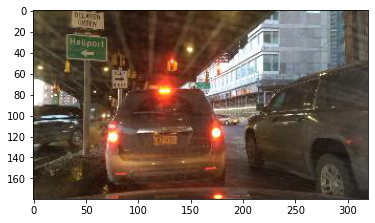

In [40]:
import matplotlib.pyplot as plt

plt.imshow( snow[0][:,:,0:3]/255)

In [55]:
out = netG_A2B(image_a)

In [59]:
out = netD_A(out)

In [60]:
out.shape

torch.Size([1, 1, 11, 20])